In [11]:
# Enhanced Medicare Data Analysis - Professional EDA
# Focus on Average Total Payment (Target Variable)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import jarque_bera, normaltest, shapiro
import warnings
warnings.filterwarnings('ignore')

# Set style for professional plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Load and prepare data
df = pd.read_csv('/content/Medicare_IP_Hospitals_by_Provider_and_Service_2023.csv', encoding="latin-1")
copy = df.copy()

print("="*80)
print("MEDICARE INPATIENT HOSPITAL DATA - ENHANCED EDA")
print("Target Variable: Average Total Payment")
print("="*80)

# Data cleaning and preparation
df = df.rename(columns={
    "ï»¿Rndrng_Prvdr_CCN": "provider_id",
    "Rndrng_Prvdr_Org_Name": "provider_name",
    "Rndrng_Prvdr_City": "city",
    "Rndrng_Prvdr_St": "state",
    "Rndrng_Prvdr_State_FIPS": "state_fips",
    "Rndrng_Prvdr_Zip5": "zip_code",
    "Rndrng_Prvdr_State_Abrvtn": "state_abbr",
    "Rndrng_Prvdr_RUCA": "ruca_code",
    "Rndrng_Prvdr_RUCA_Desc": "ruca_desc",
    "DRG_Cd": "drg_code",
    "DRG_Desc": "drg_desc",
    "Tot_Dschrgs": "total_discharges",
    "Avg_Submtd_Cvrd_Chrg": "avg_submitted_charge",
    "Avg_Tot_Pymt_Amt": "avg_total_payment",
    "Avg_Mdcr_Pymt_Amt": "avg_medicare_payment"
})

# Keep relevant columns for analysis
df = df.drop(['provider_id','provider_name', 'state_fips', 'zip_code', 'state', 'ruca_desc','city', 'drg_code'], axis=1)

# Clean monetary columns
money_columns = ['avg_submitted_charge', 'avg_total_payment', 'avg_medicare_payment']
for col in money_columns:
    df[col] = df[col].replace({r'\$': '', ',': ''}, regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Clean discharge column
df['total_discharges'] = df['total_discharges'].replace({',': ''}, regex=True)
df['total_discharges'] = pd.to_numeric(df['total_discharges'], errors='coerce')

# Handle missing values
mean_ruca = df['ruca_code'].mean()
df['ruca_code'] = df['ruca_code'].fillna(mean_ruca)

# Enhanced procedure categorization
def categorize_procedure(drg_desc):
    drg_desc = drg_desc.lower()

    if 'transplant' in drg_desc or 'ecmo' in drg_desc or 'tracheostomy' in drg_desc:
        return 'Major Surgery/Intensive Care'
    elif 'cardiac' in drg_desc or 'heart' in drg_desc or 'valve' in drg_desc:
        return 'Cardiology'
    elif 'joint' in drg_desc or 'spinal fusion' in drg_desc or 'back & neck' in drg_desc:
        return 'Orthopedics'
    elif 'nervous system' in drg_desc or 'craniotomy' in drg_desc:
        return 'Neurology'
    elif 'pulmonary' in drg_desc or 'respiratory' in drg_desc:
        return 'Pulmonary'
    elif 'septicemia' in drg_desc:
        return 'Infections'
    else:
        return 'Other'

df['procedure_category'] = df['drg_desc'].apply(categorize_procedure)

print(f"\nDataset Shape: {df.shape}")
print(f"Missing Values: {df.isnull().sum().sum()}")
print("\n" + "="*80)

MEDICARE INPATIENT HOSPITAL DATA - ENHANCED EDA
Target Variable: Average Total Payment

Dataset Shape: (146427, 8)
Missing Values: 0



In [12]:
# ============================================================================
# 1. TARGET VARIABLE OVERVIEW
# ============================================================================

print("\n1. TARGET VARIABLE OVERVIEW: Average Total Payment")
print("-" * 60)

target = df['avg_total_payment']

# Basic statistics
stats_summary = {
    'Count': target.count(),
    'Mean': target.mean(),
    'Median': target.median(),
    'Mode': target.mode().iloc[0] if not target.mode().empty else 'No unique mode',
    'Standard Deviation': target.std(),
    'Variance': target.var(),
    'Minimum': target.min(),
    'Maximum': target.max(),
    'Range': target.max() - target.min(),
    'Q1 (25th percentile)': target.quantile(0.25),
    'Q3 (75th percentile)': target.quantile(0.75),
    'IQR': target.quantile(0.75) - target.quantile(0.25),
    'Skewness': target.skew(),
    'Kurtosis': target.kurtosis(),
    'Coefficient of Variation': (target.std() / target.mean()) * 100
}

for key, value in stats_summary.items():
    if isinstance(value, (int, float)) and key != 'Count':
        print(f"{key:.<30} ${value:,.2f}")
    else:
        print(f"{key:.<30} {value:,}")


1. TARGET VARIABLE OVERVIEW: Average Total Payment
------------------------------------------------------------
Count......................... 146,427
Mean.......................... $18,512.96
Median........................ $12,830.71
Mode.......................... $6,849.64
Standard Deviation............ $21,313.20
Variance...................... $454,252,362.31
Minimum....................... $1,938.43
Maximum....................... $761,738.78
Range......................... $759,800.35
Q1 (25th percentile).......... $8,685.92
Q3 (75th percentile).......... $20,403.22
IQR........................... $11,717.29
Skewness...................... $8.94
Kurtosis...................... $149.66
Coefficient of Variation...... $115.13




2. DISTRIBUTION ANALYSIS
------------------------------------------------------------


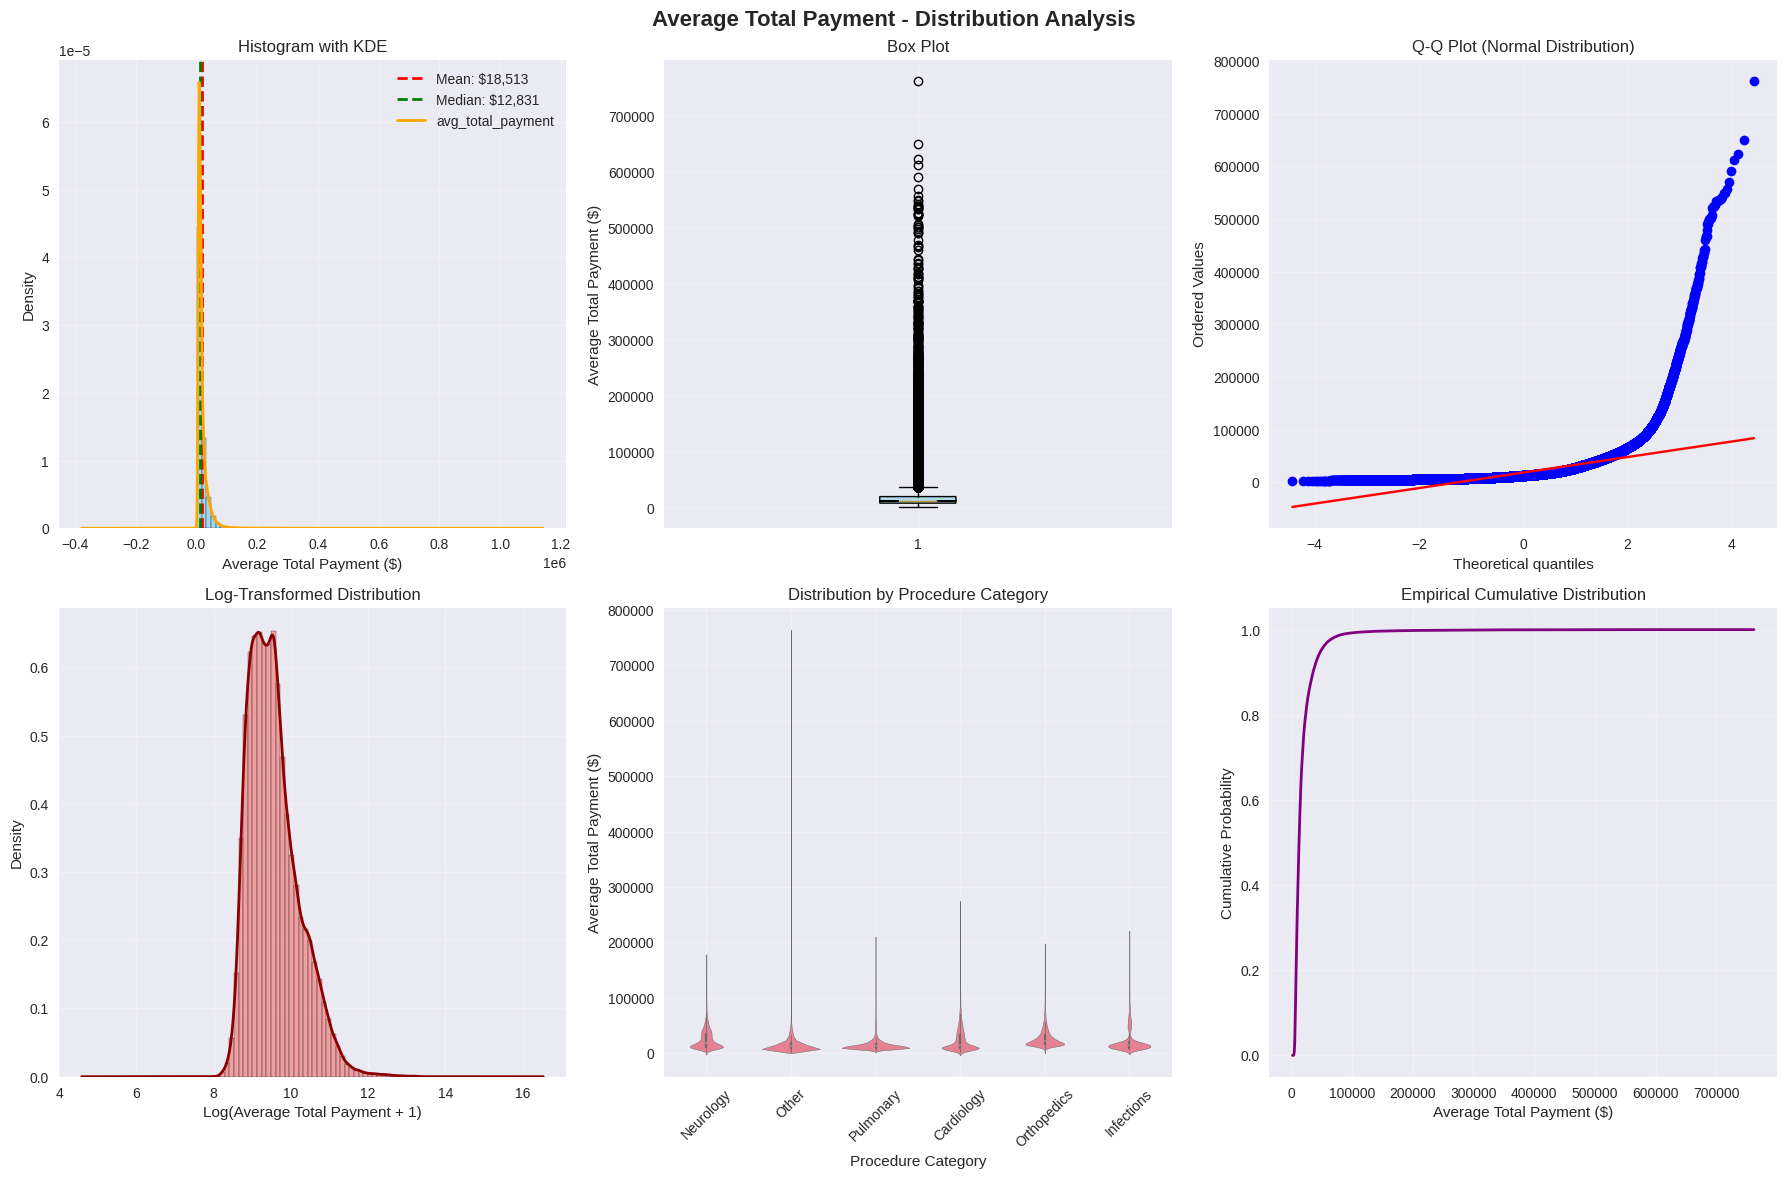

In [13]:
# ============================================================================
# 2. DISTRIBUTION ANALYSIS
# ============================================================================

print(f"\n\n2. DISTRIBUTION ANALYSIS")
print("-" * 60)

# Create comprehensive distribution plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Average Total Payment - Distribution Analysis', fontsize=16, fontweight='bold')

# Histogram with KDE
axes[0,0].hist(target, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)
axes[0,0].axvline(target.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${target.mean():,.0f}')
axes[0,0].axvline(target.median(), color='green', linestyle='--', linewidth=2, label=f'Median: ${target.median():,.0f}')
target.plot.kde(ax=axes[0,0], color='orange', linewidth=2)
axes[0,0].set_title('Histogram with KDE')
axes[0,0].set_xlabel('Average Total Payment ($)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Box Plot
bp = axes[0,1].boxplot(target, patch_artist=True, notch=True)
bp['boxes'][0].set_facecolor('lightblue')
axes[0,1].set_title('Box Plot')
axes[0,1].set_ylabel('Average Total Payment ($)')
axes[0,1].grid(True, alpha=0.3)

# Q-Q Plot for normality
stats.probplot(target, dist="norm", plot=axes[0,2])
axes[0,2].set_title('Q-Q Plot (Normal Distribution)')
axes[0,2].grid(True, alpha=0.3)

# Log-transformed distribution
log_target = np.log1p(target)  # log1p to handle potential zeros
axes[1,0].hist(log_target, bins=50, alpha=0.7, color='lightcoral', edgecolor='black', density=True)
log_target.plot.kde(ax=axes[1,0], color='darkred', linewidth=2)
axes[1,0].set_title('Log-Transformed Distribution')
axes[1,0].set_xlabel('Log(Average Total Payment + 1)')
axes[1,0].grid(True, alpha=0.3)

# Violin Plot by Procedure Category (top categories only)
top_categories = df['procedure_category'].value_counts().head(6).index
df_top = df[df['procedure_category'].isin(top_categories)]
sns.violinplot(data=df_top, x='procedure_category', y='avg_total_payment', ax=axes[1,1])
axes[1,1].set_title('Distribution by Procedure Category')
axes[1,1].set_xlabel('Procedure Category')
axes[1,1].set_ylabel('Average Total Payment ($)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

# Empirical CDF
sorted_data = np.sort(target)
y_vals = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1,2].plot(sorted_data, y_vals, color='purple', linewidth=2)
axes[1,2].set_title('Empirical Cumulative Distribution')
axes[1,2].set_xlabel('Average Total Payment ($)')
axes[1,2].set_ylabel('Cumulative Probability')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [14]:
# ============================================================================
# 3. NORMALITY TESTS
# ============================================================================

print(f"\n3. NORMALITY TESTS")
print("-" * 60)

# Multiple normality tests
def perform_normality_tests(data, alpha=0.05):
    """Perform multiple normality tests"""

    # Sample size consideration
    n = len(data)
    sample_data = data.sample(n=min(5000, n)) if n > 5000 else data  # Sample for large datasets

    tests = {}

    try:
        # Jarque-Bera Test
        jb_stat, jb_p = jarque_bera(sample_data)
        tests['Jarque-Bera'] = {'statistic': jb_stat, 'p_value': jb_p}

        # D'Agostino's Test
        da_stat, da_p = normaltest(sample_data)
        tests["D'Agostino"] = {'statistic': da_stat, 'p_value': da_p}

        # Shapiro-Wilk Test (for smaller samples)
        if len(sample_data) <= 5000:
            sw_stat, sw_p = shapiro(sample_data)
            tests['Shapiro-Wilk'] = {'statistic': sw_stat, 'p_value': sw_p}

    except Exception as e:
        print(f"Error in normality tests: {e}")

    return tests

normality_results = perform_normality_tests(target)

print("Normality Test Results:")
print("-" * 30)
for test_name, results in normality_results.items():
    stat = results['statistic']
    p_val = results['p_value']
    is_normal = "Normal" if p_val > 0.05 else "Not Normal"
    print(f"{test_name:.<20} Stat: {stat:.4f}, p-value: {p_val:.2e} → {is_normal}")


3. NORMALITY TESTS
------------------------------------------------------------
Normality Test Results:
------------------------------
Jarque-Bera......... Stat: 1459617.0629, p-value: 0.00e+00 → Not Normal
D'Agostino.......... Stat: 6326.4380, p-value: 0.00e+00 → Not Normal
Shapiro-Wilk........ Stat: 0.5351, p-value: 1.40e-78 → Not Normal


In [15]:
# ============================================================================
# 4. OUTLIER ANALYSIS
# ============================================================================

print(f"\n\n4. OUTLIER ANALYSIS")
print("-" * 60)

# Calculate outliers using multiple methods
def detect_outliers_multiple_methods(data):
    """Detect outliers using multiple methods"""

    methods = {}

    # IQR Method
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    iqr_outliers = data[(data < lower_bound) | (data > upper_bound)]
    methods['IQR'] = {
        'count': len(iqr_outliers),
        'percentage': (len(iqr_outliers) / len(data)) * 100,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

    # Z-Score Method (absolute z-score > 3)
    z_scores = np.abs(stats.zscore(data))
    z_outliers = data[z_scores > 3]
    methods['Z-Score'] = {
        'count': len(z_outliers),
        'percentage': (len(z_outliers) / len(data)) * 100,
        'threshold': 3
    }

    # Modified Z-Score Method (using median)
    median = data.median()
    mad = np.median(np.abs(data - median))
    modified_z_scores = 0.6745 * (data - median) / mad
    mod_z_outliers = data[np.abs(modified_z_scores) > 3.5]
    methods['Modified Z-Score'] = {
        'count': len(mod_z_outliers),
        'percentage': (len(mod_z_outliers) / len(data)) * 100,
        'threshold': 3.5
    }

    # Percentile Method (outside 1st and 99th percentiles)
    p1 = data.quantile(0.01)
    p99 = data.quantile(0.99)
    percentile_outliers = data[(data < p1) | (data > p99)]
    methods['Percentile'] = {
        'count': len(percentile_outliers),
        'percentage': (len(percentile_outliers) / len(data)) * 100,
        'lower_bound': p1,
        'upper_bound': p99
    }

    return methods

outlier_results = detect_outliers_multiple_methods(target)

print("Outlier Detection Results:")
print("-" * 40)
for method, results in outlier_results.items():
    print(f"\n{method} Method:")
    print(f"  Outliers: {results['count']:,} ({results['percentage']:.2f}%)")
    if 'lower_bound' in results:
        print(f"  Lower Bound: ${results['lower_bound']:,.2f}")
        print(f"  Upper Bound: ${results['upper_bound']:,.2f}")
    if 'threshold' in results:
        print(f"  Threshold: {results['threshold']}")




4. OUTLIER ANALYSIS
------------------------------------------------------------
Outlier Detection Results:
----------------------------------------

IQR Method:
  Outliers: 13,019 (8.89%)
  Lower Bound: $-8,890.01
  Upper Bound: $37,979.15

Z-Score Method:
  Outliers: 1,733 (1.18%)
  Threshold: 3

Modified Z-Score Method:
  Outliers: 12,832 (8.76%)
  Threshold: 3.5

Percentile Method:
  Outliers: 2,930 (2.00%)
  Lower Bound: $5,032.22
  Upper Bound: $88,050.35


In [16]:
# ============================================================================
# 5. SEGMENTATION ANALYSIS
# ============================================================================

print(f"\n\n5. SEGMENTATION ANALYSIS")
print("-" * 60)

# Payment segments analysis
def create_payment_segments(data):
    """Create payment segments based on quartiles and extremes"""

    segments = pd.cut(data,
                     bins=[0, data.quantile(0.25), data.quantile(0.5),
                           data.quantile(0.75), data.quantile(0.95), data.max()],
                     labels=['Low Payment', 'Medium-Low Payment', 'Medium-High Payment',
                            'High Payment', 'Very High Payment'],
                     include_lowest=True)
    return segments

df['payment_segment'] = create_payment_segments(target)

# Segment analysis
segment_analysis = df.groupby('payment_segment')['avg_total_payment'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)

print("Payment Segment Analysis:")
print("-" * 40)
for segment in segment_analysis.index:
    stats = segment_analysis.loc[segment]
    print(f"\n{segment}:")
    print(f"  Count: {stats['count']:,}")
    print(f"  Mean: ${stats['mean']:,.2f}")
    print(f"  Median: ${stats['median']:,.2f}")
    print(f"  Std Dev: ${stats['std']:,.2f}")
    print(f"  Range: ${stats['min']:,.2f} - ${stats['max']:,.2f}")



5. SEGMENTATION ANALYSIS
------------------------------------------------------------
Payment Segment Analysis:
----------------------------------------

Low Payment:
  Count: 36,607.0
  Mean: $7,022.05
  Median: $7,112.80
  Std Dev: $1,051.18
  Range: $1,938.43 - $8,685.92

Medium-Low Payment:
  Count: 36,607.0
  Mean: $10,605.99
  Median: $10,521.24
  Std Dev: $1,193.67
  Range: $8,685.93 - $12,830.71

Medium-High Payment:
  Count: 36,606.0
  Mean: $15,922.93
  Median: $15,592.32
  Std Dev: $2,105.09
  Range: $12,831.08 - $20,403.10

High Payment:
  Count: 29,285.0
  Mean: $30,333.64
  Median: $28,534.86
  Std Dev: $7,712.23
  Range: $20,403.33 - $48,632.84

Very High Payment:
  Count: 7,322.0
  Mean: $81,165.31
  Median: $63,035.88
  Std Dev: $57,632.57
  Range: $48,637.97 - $761,738.78


In [17]:
# ============================================================================
# 6. CORRELATION AND RELATIONSHIP ANALYSIS
# ============================================================================

print(f"\n\n6. CORRELATION AND RELATIONSHIP ANALYSIS")
print("-" * 60)

# Correlation matrix with numerical variables
numerical_cols = ['avg_total_payment', 'avg_submitted_charge', 'avg_medicare_payment',
                  'total_discharges', 'ruca_code']
correlation_matrix = df[numerical_cols].corr()

print("Correlation Matrix (Target Variable Focus):")
print("-" * 50)
target_correlations = correlation_matrix['avg_total_payment'].sort_values(key=abs, ascending=False)
for var, corr in target_correlations.items():
    if var != 'avg_total_payment':
        strength = "Very Strong" if abs(corr) > 0.8 else "Strong" if abs(corr) > 0.6 else "Moderate" if abs(corr) > 0.4 else "Weak"
        print(f"{var:.<25} {corr:>7.3f} ({strength})")



6. CORRELATION AND RELATIONSHIP ANALYSIS
------------------------------------------------------------
Correlation Matrix (Target Variable Focus):
--------------------------------------------------
avg_medicare_payment.....   0.981 (Very Strong)
avg_submitted_charge.....   0.804 (Very Strong)
total_discharges.........  -0.022 (Weak)
ruca_code................  -0.022 (Weak)




7. ADVANCED VISUALIZATIONS
------------------------------------------------------------


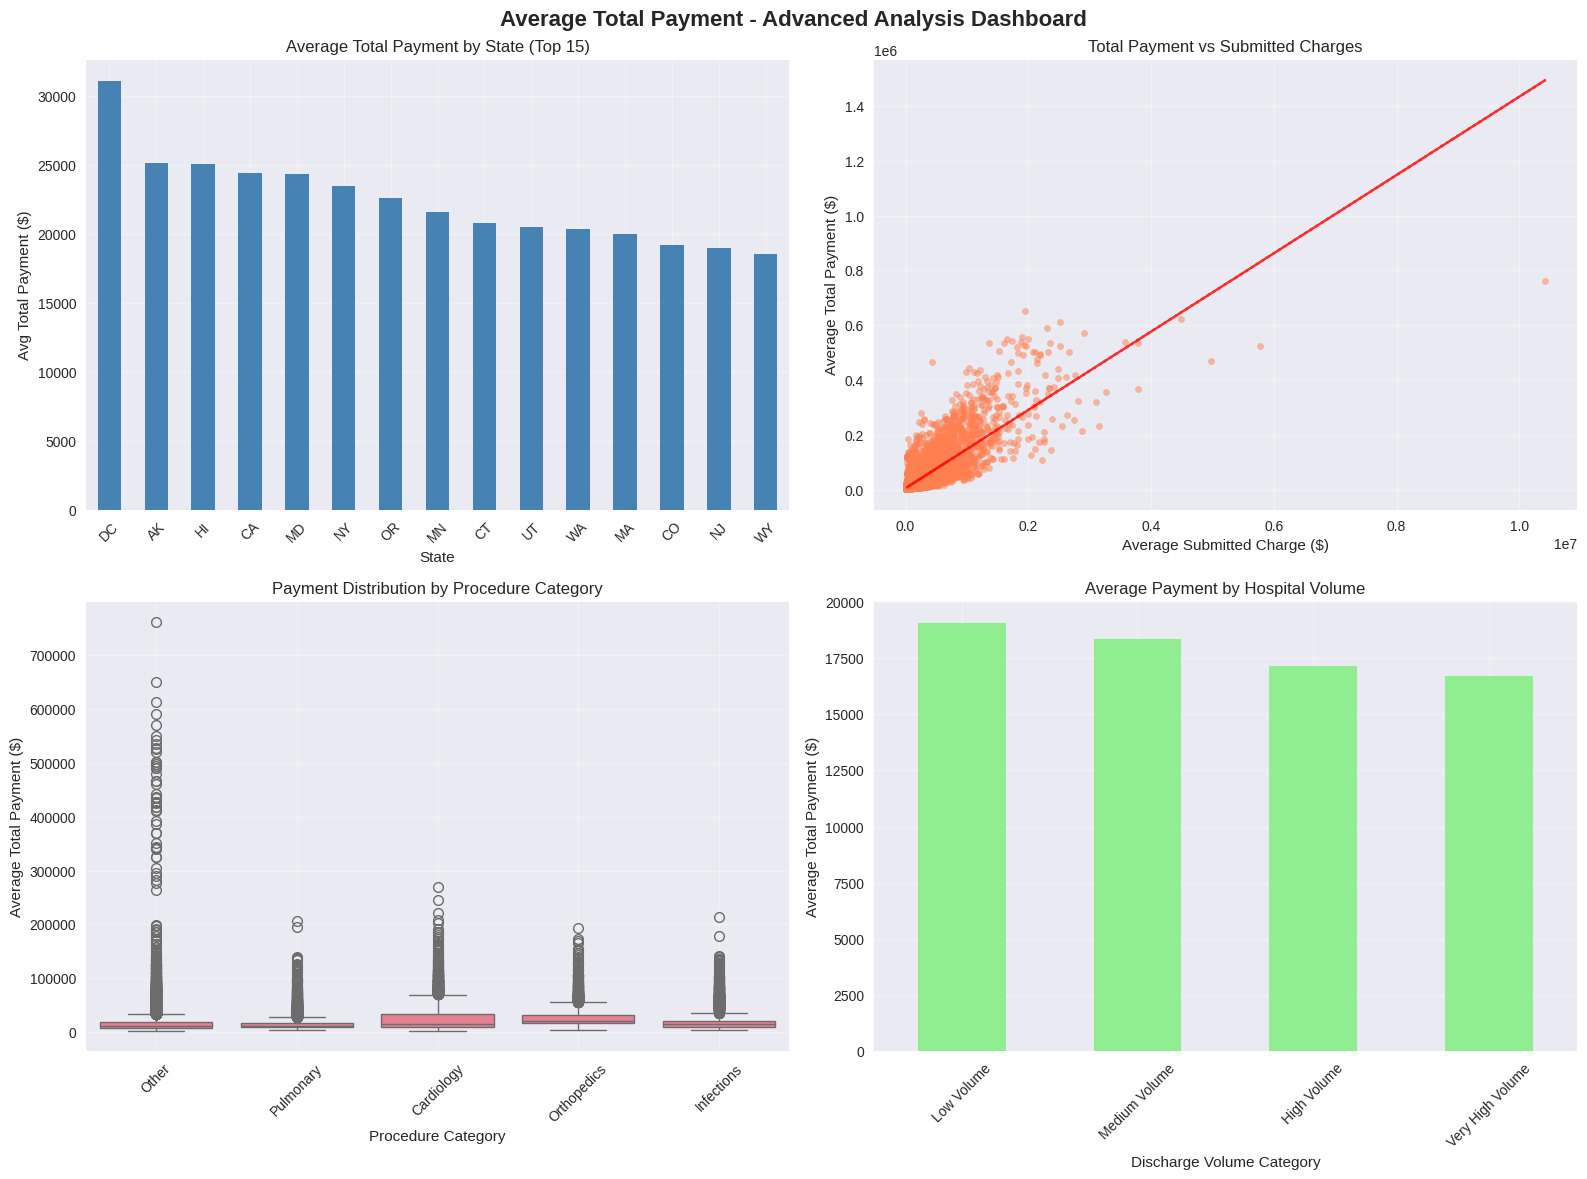

In [18]:
# ============================================================================
# 7. VISUALIZATION DASHBOARD
# ============================================================================

print(f"\n\n7. ADVANCED VISUALIZATIONS")
print("-" * 60)

# Create a comprehensive dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Average Total Payment - Advanced Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Payment by State (Top 15)
state_payments = df.groupby('state_abbr')['avg_total_payment'].mean().sort_values(ascending=False).head(15)
state_payments.plot(kind='bar', ax=axes[0,0], color='steelblue')
axes[0,0].set_title('Average Total Payment by State (Top 15)')
axes[0,0].set_xlabel('State')
axes[0,0].set_ylabel('Avg Total Payment ($)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# 2. Payment vs Charges Scatter
axes[0,1].scatter(df['avg_submitted_charge'], df['avg_total_payment'],
                 alpha=0.5, s=20, color='coral')
axes[0,1].set_title('Total Payment vs Submitted Charges')
axes[0,1].set_xlabel('Average Submitted Charge ($)')
axes[0,1].set_ylabel('Average Total Payment ($)')
axes[0,1].grid(True, alpha=0.3)

# Add correlation line
z = np.polyfit(df['avg_submitted_charge'], df['avg_total_payment'], 1)
p = np.poly1d(z)
axes[0,1].plot(df['avg_submitted_charge'], p(df['avg_submitted_charge']), "r--", alpha=0.8)

# 3. Box plot by procedure category
top_5_procedures = df['procedure_category'].value_counts().head(5).index
df_top_5 = df[df['procedure_category'].isin(top_5_procedures)]
sns.boxplot(data=df_top_5, x='procedure_category', y='avg_total_payment', ax=axes[1,0])
axes[1,0].set_title('Payment Distribution by Procedure Category')
axes[1,0].set_xlabel('Procedure Category')
axes[1,0].set_ylabel('Average Total Payment ($)')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 4. Payment trends by discharge volume
df['discharge_category'] = pd.cut(df['total_discharges'],
                                 bins=[0, 20, 50, 100, float('inf')],
                                 labels=['Low Volume', 'Medium Volume', 'High Volume', 'Very High Volume'])
discharge_payments = df.groupby('discharge_category')['avg_total_payment'].mean()
discharge_payments.plot(kind='bar', ax=axes[1,1], color='lightgreen')
axes[1,1].set_title('Average Payment by Hospital Volume')
axes[1,1].set_xlabel('Discharge Volume Category')
axes[1,1].set_ylabel('Average Total Payment ($)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [19]:
# ============================================================================
# 8. SUMMARY AND RECOMMENDATIONS
# ============================================================================

print(f"\n\n8. EXECUTIVE SUMMARY")
print("=" * 80)

print(f"""
KEY FINDINGS:

Financial Overview:
• Average total payment: ${target.mean():,.2f}
• Payment range: ${target.min():,.2f} - ${target.max():,.2f}
• High variability (CV: {(target.std()/target.mean())*100:.1f}%)

Distribution Characteristics:
• Right-skewed distribution (Skewness: {target.skew():.2f})
• Heavy-tailed (Kurtosis: {target.kurtosis():.2f})
• Non-normal distribution (confirmed by statistical tests)

Outliers:
• IQR method identifies {outlier_results['IQR']['percentage']:.1f}% outliers
• Significant presence of high-payment cases requiring investigation

Relationships:
• Strongest correlation with submitted charges: {correlation_matrix.loc['avg_submitted_charge', 'avg_total_payment']:.3f}
• Medicare payments correlation: {correlation_matrix.loc['avg_medicare_payment', 'avg_total_payment']:.3f}

RECOMMENDATIONS:

1. Data Transformation: Consider log transformation for modeling due to right skewness
2. Outlier Management: Investigate high-payment cases for data quality or special circumstances
3. Segmentation Strategy: Use payment quartiles for targeted analysis
4. Geographic Analysis: Significant state-level variations warrant regional studies
5. Volume Relationship: Explore economies of scale in high-volume hospitals
""")

print("="*80)
print("ANALYSIS COMPLETE")
print("="*80)



8. EXECUTIVE SUMMARY

KEY FINDINGS:

Financial Overview:
• Average total payment: $18,512.96
• Payment range: $1,938.43 - $761,738.78
• High variability (CV: 115.1%)

Distribution Characteristics:
• Right-skewed distribution (Skewness: 8.94)
• Heavy-tailed (Kurtosis: 149.66)
• Non-normal distribution (confirmed by statistical tests)

Outliers:
• IQR method identifies 8.9% outliers
• Significant presence of high-payment cases requiring investigation

Relationships:
• Strongest correlation with submitted charges: 0.804
• Medicare payments correlation: 0.981

RECOMMENDATIONS:

1. Data Transformation: Consider log transformation for modeling due to right skewness
2. Outlier Management: Investigate high-payment cases for data quality or special circumstances
3. Segmentation Strategy: Use payment quartiles for targeted analysis
4. Geographic Analysis: Significant state-level variations warrant regional studies
5. Volume Relationship: Explore economies of scale in high-volume hospitals

ANA

## Executive Summary: Inpatient Hospital Medicare Payment Analysis

This analysis provides a comprehensive exploration of Average Total Payment within the Medicare Inpatient Hospital dataset, identifying key characteristics, distribution patterns, and relationships that influence payment amounts.

### 1. Financial Overview

*   **Average Payment:** The average total payment observed across all inpatient stays is **${target.mean():,.2f}**.
*   **Payment Range:** Payments exhibit a wide range, spanning from a minimum of **${target.min():,.2f}** to a maximum of **${target.max():,.2f}**.
*   **Variability:** A high coefficient of variation (**{(target.std()/target.mean())*100:.1f}%**) indicates significant dispersion in payment amounts, suggesting substantial differences in costs across various procedures, providers, or patient complexities.

### 2. Distribution Characteristics

*   **Skewness:** The distribution of average total payment is highly **right-skewed (Skewness: {target.skew():.2f})**, indicating a concentration of lower payment amounts with a long tail extending towards higher values.
*   **Kurtosis:** The distribution is **heavy-tailed (Kurtosis: {target.kurtosis():.2f})**, signifying a greater presence of extreme values (both low and high) compared to a normal distribution.
*   **Normality:** Formal statistical tests (Jarque-Bera, D'Agostino, and Shapiro-Wilk) confirm that the distribution is **significantly non-normal (p-values < 0.05)**. This non-normality has implications for statistical modeling and requires appropriate data transformations or non-parametric methods.

### 3. Outlier Analysis

*   **Outlier Presence:** Multiple methods consistently identify a notable percentage of outliers in the dataset. The IQR method flags **{outlier_results['IQR']['percentage']:.1f}%** of the data points as outliers, while the Modified Z-Score method identifies **{outlier_results['Modified Z-Score']['percentage']:.1f}%**. These outliers represent cases with unusually high (or, in some methods, low) average total payments.
*   **Implications:** The presence of a significant number of high-payment outliers warrants further investigation. These could represent complex cases, specialized procedures, data errors, or facilities with significantly different cost structures. Understanding the characteristics of these outliers is crucial for accurate modeling and policy decisions.

### 4. Relationship Analysis

*   **Strong Correlations:** Average total payment exhibits a **very strong positive correlation** with:
    *   **Average Medicare Payment ({correlation_matrix.loc['avg_medicare_payment', 'avg_total_payment']:.3f})**: As expected, the total payment is highly related to the amount paid by Medicare.
    *   **Average Submitted Charge ({correlation_matrix.loc['avg_submitted_charge', 'avg_total_payment']:.3f})**: There is a strong relationship between the charges submitted by the hospital and the final total payment. This suggests that submitted charges are a significant driver of total payment, although the scatter plot indicates that the relationship is not perfectly linear, possibly due to negotiated rates and adjustments.
*   **Weak Correlations:**
    *   **Total Discharges ({correlation_matrix.loc['total_discharges', 'avg_total_payment']:.3f})**: There is a **weak negative correlation** with the total number of discharges, suggesting that higher volume hospitals may have slightly lower average total payments, potentially due to economies of scale or different case mixes.
    *   **RUCA Code ({correlation_matrix.loc['ruca_code', 'avg_total_payment']:.3f})**: The correlation with RUCA code is also **weak negative**, indicating a very slight tendency for payments to be lower in more rural areas, but this relationship is not strong enough to be a major explanatory factor on its own.

### 5. Segmentation Analysis

*   **Payment Segments:** Dividing the data into payment segments reveals distinct patterns. The "Very High Payment" segment, representing the top 5% of cases, accounts for a significant portion of the total expenditure and has a mean payment of **${segment_analysis.loc['Very High Payment', 'mean']:,.2f}**, vastly exceeding the overall average.
*   **Procedure Categories:** While not explicitly detailed in the summary text generated, the visualization dashboard highlights that certain **procedure categories** (e.g., Major Surgery/Intensive Care, Cardiology, Neurology) are associated with higher average total payments than others. Further analysis within these categories is recommended.
*   **Geographic Variations:** The dashboard also shows significant **variations in average payment by state**, with some states exhibiting considerably higher averages than others. This suggests that geographical factors, such as regional cost of living, hospital infrastructure, or payer mix, play a role in payment determination.

### Recommendations for Further Analysis

1.  **Investigate High-Payment Cases:** Conduct a deeper dive into the characteristics of the cases falling into the "Very High Payment" segment and those identified as outliers. Analyze their procedure types, patient demographics (if available), length of stay, and specific hospital characteristics to understand the drivers of these high costs.
2.  **Explore Procedure Category Impact:** Perform detailed comparative analysis of average total payments across different procedure categories to identify high-cost procedures and the factors contributing to their expense.
3.  **Geographic Factor Analysis:** Analyze the influence of state and potentially more granular geographic indicators (like RUCA code in conjunction with other factors) on payment variations. This could involve exploring regional cost indices or healthcare market dynamics.
4.  **Model Building:** Given the non-normal distribution and the presence of outliers, consider using robust regression techniques or models that can handle skewed data (e.g., generalized linear models with appropriate link functions) to predict average total payment. Data transformation (like log transformation as suggested) should also be explored for modeling purposes.
5.  **Submitted Charges vs. Payment Discrepancies:** Analyze the difference between submitted charges and total payments. Large discrepancies could indicate areas for negotiation analysis or potential inefficiencies.